In [189]:
%matplotlib inline

# Group Members:
Erik Ström

# Imports

In [284]:
import numpy as np 
import random
import math 
import matplotlib.pyplot as plt

# Painter_play 

In [247]:
# %Floor painter algorithm
# %Code translated into python Fiona Skerman from matlab code written by Alex Szorkovszky for UU Modelling Complex Systems

# %INPUTS
# %rules: 54-cell array with one of three actions: 0(no turn) 1(turn left) 2(turn right) 3(random turn left/right)
# %room: MxN matrix defining a rectangular room with each square either 0(empty) or 1(furniture) or 2(painted)


# Chromosome (54-cell rule array) encodes action for each of 54 different scenarios
# no turn, turn left, turn right, turn left/right with 50/50 
# let [c, f, l, r] denote the states of current, forward, left and right squares, 
# then rule for that position is at position i=2(9f+3l+r)+Indicator[c=2] in chromosone.


#Painter has a position x,y in MxN matrix, and a direction -1 Left, 0 Up, 1 Right, -2 Down.

# Each time step consists of three parts
# a) according to rule on current environment update direction either 0 no turn, 1 turn left, 2 turn right, 3 random turn left/right
# b) if on unpainted square, paint it
# c) go forwards if possible

# OUTPUTS
# score: percentage of empty space painted
# xpos: x positions over time
# ypos: y positions over time



def painter_play(rules,room):
  #returns score, xpos, ypos

  M, N = room.shape

  #Calculates number of squares t to be painted. / #steps allowed
  t=M*N - room.sum()
  t=int(t)


  # add walls
  # env 0 - empty square, 1 - wall/obstruction, 2 - painted square
  env = np.ones((M+2,N+2))
  #for i in range(1, M+1):
  #  for j in range(1, N+1):
  #    env[i][j]=0
  env[1:M+1, 1:N+1] = 0

  #new room size including walls
  M=M+2
  N=N+2

  xpos=[np.nan]*(t+1)
  ypos=[np.nan]*(t+1)

  # %random initial location   
  idx = random.choice(np.argwhere(env == 0))
  xpos[0], ypos[0] = idx[0], idx[1]


  # random itial orientation (up=0,left=-1,right=+1,down=-2)
  direction = random.randint(-2, 1)

  # initial score
  score = 0

  for i in range(t):
    # directions -1: Left, 0: Up, 1: Right, 2: Down
    # dx, dy of a forward step (given current direction)        
    dx = divmod(direction,2)[1]
    if direction == -1:
      dx = -1 * dx

    dy = divmod(direction+1,2)[1]
    if direction == -2: 
      dy = -1*dy




    # dx, dy of a square to right (given currection direction)  
    r_direction=direction+1
    if r_direction == 2:
      r_direction = -2

    dxr = divmod(r_direction,2)[1]
    if r_direction == -1:
      dxr = -1 * dxr
    dyr = divmod(r_direction+1,2)[1]
    if r_direction == -2: 
      dyr = -1*dyr

    # evaluate surroundings (forward,left,right)
    local = [env[xpos[i] + dx, ypos[i] + dy], env[xpos[i] - dxr, ypos[i] - dyr], env[xpos[i] + dxr, ypos[i] + dyr]]      
      
    #localnum= 2* np.dot([9,3,1], local) if env[xpos[i], ypos[i]] == 2 else 2* np.dot([9,3,1], local) + 1
    localnum= int(2* np.dot([9,3,1], local))
    if env[xpos[i], ypos[i]] == 2:
       localnum += 1
     
    #use turning rule 1 'turn left', 2 'turn right', 3 'turn left/right 50/50 probabilities'
    if rules[localnum] == 3:
      dirchange = math.floor(random.random()*2)+1
    else:
      dirchange = rules[localnum]

    if dirchange == 1:
      direction = direction - 1
      if direction == -3:
        direction = 1
    elif dirchange == 2:
      direction = direction + 1
      if direction == 2:
        direction = -2

    dx = divmod(direction,2)[1]
    if direction == -1:
      dx = -1 * dx

    dy = divmod(direction+1,2)[1]
    if direction == -2: 
      dy = -1*dy  

    # paint square
    if env[xpos[i],ypos[i]]==0:
      env[xpos[i],ypos[i]] = 2
      score = score + 1
      
    # go forward if possible - stay put if wall/obstacle ahead
    if env[xpos[i]+dx, ypos[i]+dy] == 1:
      xpos[i+1] = xpos[i]
      ypos[i+1] = ypos[i]
    else:
      xpos[i+1] = xpos[i]+dx
      ypos[i+1] = ypos[i]+dy      
  

  # %normalise score by time            
  score = score/t  

  return score, xpos, ypos, #env


# Part 1
## GA
We start by defining some helper functions that performs the crossover, calculates fitness and so forth.

## GA rules
We use one-point crossover where we define some number of parents where pairs of two best scoring specimens cross over and generate two children where the children recieve different parts of the parents chromosome. This way, if a parent has a good "half" it is not lost. 

One improvement could be to use k-point crossover, however each boundary seems to present some issues where the more boundaries has to be connected per children the more difficult it might be (or it might not be? though probably is) to find parents such that the boundaries are constructed properly.  

Similarly, we could also use multiple pairs for the parents, and have different top performing pairs generate children however for simplicity we only do the closest two parents. 

For each generation, the worst performing specimens from the previous generation is replaced with children from the top performing specimens, where we still leave some room for the top performing specimens to remain in the population in case the crossover leads to worse score. 

The children also recieve random mutations by a mutation probability

In [233]:
def chromosome_initialize(size):
    '''
    size: size

    Returns a random chromosome
    '''
    return np.random.randint(4, size=size)

def crossover(parent1, parent2):
    '''
    parent1: chromosome
    parent2: chromosome

    returns the one-point crossover of the parents
    TODO: use k-point?
    '''
    crossover_point = len(parent1) // 2
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    assert(child is not None)
    return child

def mutate(chromosome, mutation_probability):
    '''
    chromosome: 51x1 array
    mutation_probability: probability a single cell is mutated

    returns: mutated chromosome   
    '''
    for i in range(len(chromosome)):
        if np.random.uniform() < mutation_probability:
            chromosome[i] = np.random.randint(0, high=3)
    return chromosome

def generation_advance(chromosomes: list, fitness: list, n_parents: int, mutation_probability: float):
    '''
    chromosomes: a list containing chromosomes
    fitness: a dictionairy containing the fitneess scores (val) for each chromosome (key)
    n_parents: how many parents should exist each genereation

    Given the chromosomes and their fitness scores, returns a new list of chromosomes
    based on some GA update rules.

    Note: fitness dict assumed to be sorted already
    '''
    
    for i in range(n_parents):
        # adds chromosomes in "backwards" order
        # by getting the index of the worst performers w.r.t fitness
        # and then replacing it with offspring from the "best" ones
        assert(chromosomes[fitness[i]] is not None)
        chromosomes[fitness[-2*i-1]] = mutate(crossover(chromosomes[fitness[i]], chromosomes[fitness[i+1]]), mutation_probability)
        chromosomes[fitness[-2*(i-1)]] = mutate(crossover(chromosomes[fitness[i+1]], chromosomes[fitness[i]]), mutation_probability)

def painter_fitness(chromosomes, room, n_chromosomes, n_simulations):
    '''
    chromosomes: Chromosomes 
    room: The room
    n_chromosomes: number of chromosomes
    n_simulations: number of games to play for each chromosome

    Runs the game and calculates the score for each chromosomes and returns
    a sorted list (by fitness score) of the indices of the chromosomes corresponding
    to that score position.

    e.g.
    fitness_indices[0] = index of best scoring chromosome
    fitness_indices[-1] = index of worst scoring chromosome

    could also return the fitness list if you want the fitness of the whole generation
    '''
    fitness = dict()
    for c_i in range(n_chromosomes):
        fitness_score = 0
        for _ in range(n_simulations):
            score, _, _ = painter_play(chromosomes[c_i], room=room)    
            fitness_score += score
        fitness[c_i] = fitness_score / n_simulations

    fitness_indices = sorted(fitness, key=fitness.get, reverse=True) #sorted(fitness.items(), key=lambda x:x[1])

    return fitness_indices, fitness[fitness_indices[0]]
    
def painter_optimize(room, n_chromosomes=100, n_parents = 20, n_generations=200, n_simulations = 10, mutation_probability = 0.005):
    '''
    room: room for the game
    n_generations: number of generations to simulate for

    Initializes a number of chromosomes and runs the genetic algorithm for a number of generations.
    
    Returns the best chromosome as well as the best score for each generation
    '''
    chromosome_size = (54, 1)
    # initialize chromosomes
    chromosomes = []
    for i in range(n_chromosomes):
        chromosomes.append(chromosome_initialize(chromosome_size))

    # GA main loop
    fitness_scores = [] #best fitness per generation
    for n in range(n_generations):
        fitness_indices, best_fitness = painter_fitness(chromosomes=chromosomes, room=room, n_chromosomes=n_chromosomes, n_simulations=n_simulations)
        fitness_scores.append(best_fitness)
        generation_advance(chromosomes=chromosomes, fitness=fitness_indices, n_parents=n_parents, mutation_probability=mutation_probability)

        if n % 5 == 0:
            print(f"{n} / {n_generations}, best: {max(fitness_scores)}")

    # report / calculate score for the last generation too
    fitness_indices, best_fitness = painter_fitness(chromosomes=chromosomes, room=room, n_chromosomes=n_chromosomes, n_simulations=n_simulations)
    fitness_scores.append(best_fitness)
    print(f"{n+1} / {n_generations}, best score: {max(fitness_scores)}")

    return chromosomes[fitness_indices[0]], fitness_scores

## Results:

In [322]:
# params
n_chromosomes = 60
n_parents = 24
assert(n_parents * 2 < n_chromosomes) # each parent will have 2 children

n_generations = 100
n_simulations = 5
mutation_probability = 0.1

room = np.zeros((30,60))

best_chromosome, fitness_scores = painter_optimize(room, n_chromosomes=n_chromosomes, n_parents=n_parents, n_generations=n_generations, n_simulations=n_simulations, mutation_probability=mutation_probability)
print(f"Final generation sample: {best_chromosome.flatten()}\n")

score, dx, dy = painter_play(best_chromosome, room=room)  

painter_walk = np.stack((dx, dy), axis=1)
for pos in painter_walk:
    print(pos, end=" > ")
print(f"\nscore: {score}")

0 / 100, best: 0.47055555555555556
5 / 100, best: 0.9144444444444446
10 / 100, best: 0.9653333333333333
15 / 100, best: 0.9883333333333333
20 / 100, best: 0.9883333333333333
25 / 100, best: 0.9883333333333333
30 / 100, best: 0.9883333333333333
35 / 100, best: 0.9883333333333333
40 / 100, best: 0.9922222222222222
45 / 100, best: 0.9922222222222222
50 / 100, best: 0.9922222222222222
55 / 100, best: 0.9948888888888888
60 / 100, best: 0.9948888888888888
65 / 100, best: 0.9948888888888888
70 / 100, best: 0.9948888888888888
75 / 100, best: 0.9948888888888888
80 / 100, best: 0.9948888888888888
85 / 100, best: 0.9948888888888888
90 / 100, best: 0.9953333333333333
95 / 100, best: 0.9953333333333333
100 / 100, best score: 0.9953333333333333
Final generation sample: [2 2 0 1 0 0 0 0 0 1 0 2 2 1 2 2 0 2 2 2 1 1 1 1 2 2 1 1 0 2 0 2 1 1 0 2 0
 2 0 1 1 1 2 2 1 1 2 2 0 2 1 2 0 0]

[24 32] > [25 32] > [25 31] > [24 31] > [23 31] > [23 32] > [23 33] > [24 33] > [25 33] > [26 33] > [26 32] > [26 31] > [2

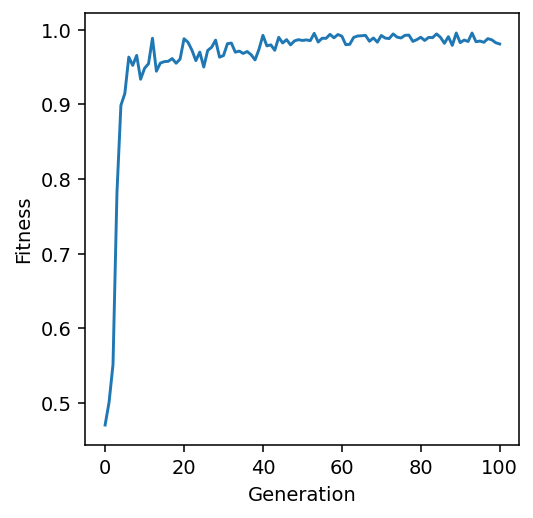

In [323]:
plt.rcParams['figure.figsize'] = [4.0, 4.0]
plt.rcParams['figure.dpi'] = 140

plt.plot(fitness_scores)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.show()

Due to how the painter_play function is implemented, running a "game" takes quite some time where it is not really feasible to run 200 chromosomes for multiple simulations per chromosome, and thus we settle with the parameters above where we can still clearly see that we seem to be converging to some optimal policy. Already 5 simulations is already quite few where the more randomness we have per evaluation the longer it will take to find the optimal chromosome.

The optimal policy itself could probably be seen as a "sinkless" vector field without cycles or points that are attracting, i.e. no trajectory on the field leads back to itself.  

# 2 Triangles
Here, we assume that the original triangle chosen is the triangle formed between the origin, $(0, 1)$, and $(1, 0)$. 

The random original point is chosen by choosing points in the unit square until they are below the line $y = -x + 1$, though on second though we could just have chosen an arbitrary point of our liking instead since we only use the random point once...

In [295]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 140

In [249]:
def random_point_within_triangle():
    '''
    Returns a random point within the triangle formed from the origin to (1, 0) and (0, 1)
    by selecting a random point within the unit square and discarding points outside the triangle.
    This should yield uniform samples as described by:
    https://mathworld.wolfram.com/TrianglePointPicking.html
    '''
    p = np.random.uniform(size=(2))
    y = -p[0] + 1 # equation of the line that splits our unit square, lower half defines our triangle

    while True:
        if p[1] <= y: # if our generated point is below the line, return the point
            return p[0], p[1]
        else: # otherwise generate a new point
            p = np.random.uniform(size=(2))
            y = -p[0] + 1


Make sure we generate reasonable points

(0.0, 1.0)

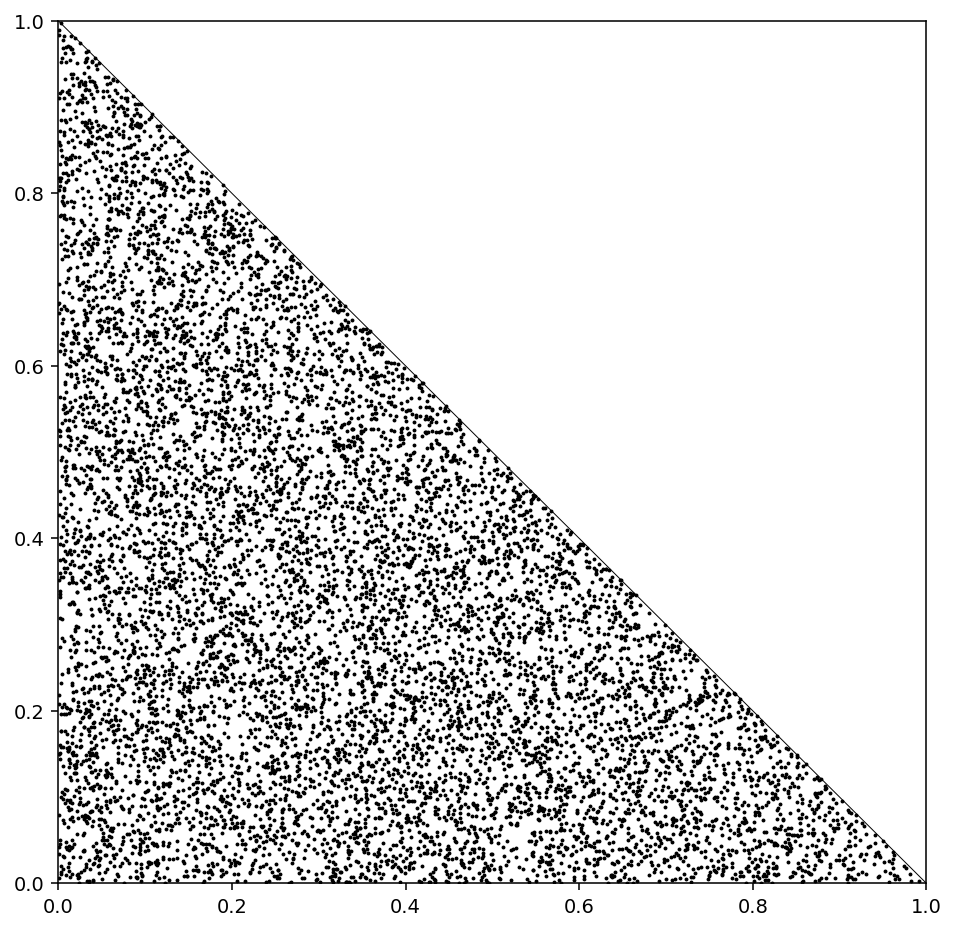

In [293]:
x, y = [], []
for _ in range(10000):
    px, py = random_point_within_triangle()
    x.append(px)
    y.append(py)

plt.plot(x, y, 'ko', markersize=1)
plt.plot([1, 0], [0, 1], color='k', linestyle='solid', linewidth=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])

Looks reasonable! 

In [314]:
def iterated_triangle(p1, p2, p3, n_iterations):
    '''
    p1: probability for vertex 1
    p2: probability for vertex 2
    p3: probability for vertex 3
    n_iterations: number of iterations to run the simulation for
    
    Runs the algorithm for n_iterations
    '''
    vertex_indices = [0, 1, 2] 
    # define the points corresponding to the indices so that there are no 
    # ambigouities
    vertex_points = {0: [0, 0], 1: [0, 1], 2: [1, 0]} 

    x = []
    y = []

    point = random_point_within_triangle()
    probs = [p1, p2, p3]
    for i in range(n_iterations):
        random_vertex = vertex_points[np.random.choice(vertex_indices, 1, p=probs)[0]]
        point = (random_vertex[0] + point[0]) / 2, (random_vertex[1] + point[1]) / 2
        x.append(point[0])
        y.append(point[1])
    return x[100:], y[100:]

(0.0, 1.0)

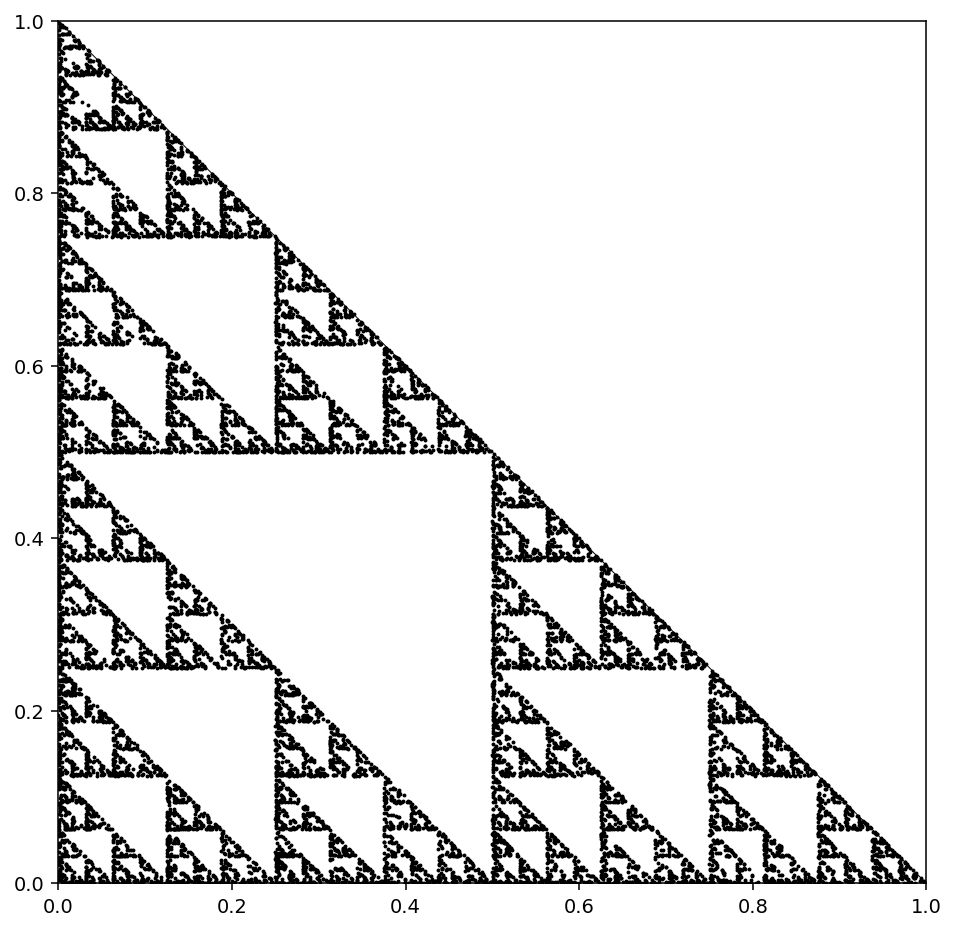

In [311]:
p1 = 1/3
p2 = 1/3
p3 = 1/3
n_iterations = 15000

x, y = iterated_triangle(p1, p2, p3, n_iterations)

plt.plot(x, y, 'ko', markersize=1)
plt.plot([1, 0], [0, 1], color='k', linestyle='solid', linewidth=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])

## Question 1: 
### What do you obtain as the limit set if p1 = p2 = p3 ? What do you obtain if they are not equal?
The limiting set is the Sierpiński gasket.

This should be the case even if $p_1, p_2, p_3$ are not equal, only the set will take "longer" to form.

## Question 2: 
### Write out the iterated function system which describes this process.
$f_1(x_1, x_2) = \frac{(0,0) + (x_1, x_2)}{2}$

$f_2(x_1, x_2) = \frac{(0,1) + (x_1, x_2)}{2}$

$f_3(x_1, x_2) = \frac{(1,0) + (x_1, x_2)}{2}$